Link to the notebook: https://tinyurl.com/yxnukm2f
Copy the notebook to your GDrive to edit.

# Download prerequisite packages

First we will install extra packages which aren't included in the default colab environment. In this case, we are just installing the `bpemb` package, which will enable us to use word-pieces for tokenization.

`bpemb` provide pretrained word-piece embeddings based on Byte-Pair encoding (BPE). BPE works by iteratively building a vocabulary of size N via merging the most frequent character n-grams from a large text corpus (e.g. Wikipedia). Read more [here](https://github.com/bheinzerling/bpemb) 

In [ ]:
!pip install bpemb

Here we are just using some magic commands to make sure changes to external packages are automatically loaded and plots are displayed in the notebook.

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Ensuring reproducible results

Before we do anything else, we need to make sure that we seed all of the random number generators and set some flags to ensure that our results are reproducible across runs i.e. that we get the same result every time we run our code. **Question:** Why do we need to do this?

In [ ]:
import torch
import random
import numpy as np

In [ ]:
def enforce_reproducibility(seed=42):
    # Sets seed manually for both CPU and CUDA
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # For atomic operations there is currently 
    # no simple way to enforce determinism, as
    # the order of parallel operations is not known.
    # CUDNN
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # System based
    random.seed(seed)
    np.random.seed(seed)

In [ ]:
enforce_reproducibility()

# Upload the dataset 
https://www.cs.ucsb.edu/~william/data/liar_dataset.zip

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving test.tsv to test (2).tsv
Saving train.tsv to train (2).tsv
Saving valid.tsv to valid (2).tsv
User uploaded file "test.tsv" with length 301118 bytes
User uploaded file "train.tsv" with length 2408165 bytes
User uploaded file "valid.tsv" with length 301556 bytes


# Read in the data

One of the first steps is defining how data is read into the model. We'll initially read the different splits into different pandas data frames and print out some of the data to look at the format. Based on the format of the data, we don't treat the first line as a header and fill in any missing values with an empty string for ease of processing.

In [ ]:
import pandas as pd

In [ ]:
train_data = pd.read_csv('./train.tsv', sep='\t', header=None).fillna('')
valid_data = pd.read_csv('./valid.tsv', sep='\t', header=None).fillna('')
test_data = pd.read_csv('./test.tsv', sep='\t', header=None).fillna('')
valid_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,12134.json,barely-true,We have less Americans working now than in the...,"economy,jobs",vicky-hartzler,U.S. Representative,Missouri,republican,1,0,1,0,0,an interview with ABC17 News
1,238.json,pants-fire,"When Obama was sworn into office, he DID NOT u...","obama-birth-certificate,religion",chain-email,,,none,11,43,8,5,105,
2,7891.json,false,Says Having organizations parading as being so...,"campaign-finance,congress,taxes",earl-blumenauer,U.S. representative,Oregon,democrat,0,1,1,1,0,a U.S. Ways and Means hearing
3,8169.json,half-true,Says nearly half of Oregons children are poor.,poverty,jim-francesconi,Member of the State Board of Higher Education,Oregon,none,0,1,1,1,0,an opinion article
4,929.json,half-true,On attacks by Republicans that various program...,"economy,stimulus",barack-obama,President,Illinois,democrat,70,71,160,163,9,interview with CBS News


From the Liar, Liar [github page](https://github.com/thiagorainmaker77/liar_dataset), the columns have the following meanings:

```
Column 1: the ID of the statement ([ID].json).
Column 2: the label.
Column 3: the statement.
Column 4: the subject(s).
Column 5: the speaker.
Column 6: the speaker's job title.
Column 7: the state info.
Column 8: the party affiliation.
Column 9-13: the total credit history count, including the current statement.
9: barely true counts.
10: false counts.
11: half true counts.
12: mostly true counts.
13: pants on fire counts.
Column 14: the context (venue / location of the speech or statement).
```

In our case, we are interested in the second and third columns (label, statement).

# Reading data into a model

A simple and common way that data is read in PyTorch is to use the two following classes: `torch.utils.data.Dataset` and `torch.utils.data.DataLoader`. 

The `Dataset` class can be extended to read in and store the data you are using for your experiment. The only requirements are to implement the `__len__` and `__getitem__` methods. `__len__` simply returns the size of your dataset and `__getitem__` takes an index and returns that sample from your dataset, processed in whatever way is necessary to be input to your model.

The `DataLoader` class determines how to iterate through your `Dataset`, including how to shuffle and batch your data.



In [ ]:
from torch.utils.data import Dataset, DataLoader
from typing import List, Tuple

# Some globals which determine the number of labels and their indices
label_map = {l:i for i,l in enumerate((set(train_data.values[:,1]) | set(valid_data.values[:,1]) | set(test_data.values[:,1])))}
num_labels = len(label_map)

print(label_map)

{'mostly-true': 0, 'true': 1, 'false': 2, 'pants-fire': 3, 'barely-true': 4, 'half-true': 5}


This is a utility function which, given a list of text samples and a tokenizer, will tokenize the text and return the IDs of the tokens in the vocabulary. The tokenizer will split the text into individual word-pieces and convert these to IDs in the tokenizer vocabulary. In addition, it will return the length of each sequence, which is needed when inputting padded data into an RNN in PyTorch.

In [ ]:
def text_to_batch_bilstm(text: List, tokenizer) -> Tuple[List, List]:
    """
    Creates a tokenized batch for input to a bilstm model
    :param text: A list of sentences to tokenize
    :param tokenizer: A tokenization function to use (i.e. fasttext)
    :return: Tokenized text as well as the length of the input sequence
    """
    # Some light preprocessing
    input_ids = [tokenizer.encode_ids_with_eos(t) for t in text]

    return input_ids, [len(ids) for ids in input_ids]

This is another utility function which defines how to combine data into a batch. Importantly, it determines the max length of a sequence in the batch and pads all of the samples with a `[PAD]` ID to this length.

In [ ]:
def collate_batch_bilstm(input_data: Tuple) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Combines multiple data samples into a single batch
    :param input_data: The combined input_ids, seq_lens, and labels for the batch
    :return: A tuple of tensors (input_ids, seq_lens, labels)
    """
    input_ids = [i[0][0] for i in input_data]
    seq_lens = [i[1][0] for i in input_data]
    labels = [i[2] for i in input_data]

    max_length = max([len(i) for i in input_ids])

    # Pad all of the input samples to the max length (25000 is the ID of the [PAD] token)
    input_ids = [(i + [25000] * (max_length - len(i))) for i in input_ids]

    # Make sure each sample is max_length long
    assert (all(len(i) == max_length for i in input_ids))
    return torch.tensor(input_ids), torch.tensor(seq_lens), torch.tensor(labels)

This is the class which reads the dataset and processes indivudal samples. It is initialized with a pandas `DataFrame` and a tokenizer.

In [ ]:
# This will load the dataset and process it lazily in the __getitem__ function
class ClassificationDatasetReader(Dataset):
  def __init__(self, df, tokenizer):
    self.df = df
    self.tokenizer = tokenizer

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.values[idx]
    # Calls the text_to_batch function
    input_ids,seq_lens = text_to_batch_bilstm([row[2]], self.tokenizer)
    label = label_map[row[1]]
    return input_ids, seq_lens, label

Here we can test whether or not our implementation is correct. We first load english `bpemb` embeddings, which will be used to initialize the word embedding layer of our model, and the tokenizer which will be used in the dataset reader.

In [ ]:
from bpemb import BPEmb

# Load english model with 25k word-pieces
bpemb_en = BPEmb(lang='en', dim=300, vs=25000)
# Extract the embeddings and add a randomly initialized embedding for our extra [PAD] token
pretrained_embeddings = np.concatenate([bpemb_en.emb.vectors, np.zeros(shape=(1,300))], axis=0)
# Extract the vocab and add an extra [PAD] token
vocabulary = bpemb_en.emb.index2word + ['[PAD]']

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
valid_data.values[0,1:3]

array(['barely-true',
       'We have less Americans working now than in the 70s.'],
      dtype=object)

In [ ]:
reader = ClassificationDatasetReader(valid_data, bpemb_en)
reader[0]

([[415, 309, 1577, 4738, 2141, 974, 538, 26, 7, 39, 24920, 24935, 2]], [13], 4)

In [ ]:
print([vocabulary[415], vocabulary[309], vocabulary[1577], 
 vocabulary[4738], vocabulary[2141], vocabulary[974], 
 vocabulary[538], vocabulary[26], vocabulary[7], vocabulary[39], 
 vocabulary[24920], vocabulary[24935], vocabulary[2]])

print(label_map['barely-true'])

['▁we', '▁have', '▁less', '▁americans', '▁working', '▁now', '▁than', '▁in', '▁the', '▁00', 's', '.', '</s>']
4


If you are working with a rather large dataset and don't want to store it in memory, you can instead implement a dataset reader which reads from the file directly.

In [ ]:
# If you have a very large dataset and you don't want to store it in memory:
import subprocess
import linecache
import csv

class ClassificationDatasetReaderMem(Dataset):
  def __init__(self, filename, tokenizer):
    self.tokenizer = tokenizer
    self.filename = filename
    self.len = int(subprocess.check_output("wc -l " + filename, shell=True).split()[0])

  def __len__(self):
    return self.len

  def __getitem__(self, idx):
    line = linecache.getline(self.filename, idx + 1)
    row = next(csv.reader([line], delimiter='\t'))
    input_ids, seq_lens = text_to_batch_bilstm([row[2]], self.tokenizer)
    label = label_map[row[1]]
    return input_ids, seq_lens, label

reader = ClassificationDatasetReaderMem('./valid.tsv', bpemb_en)
reader[0]

([[415, 309, 1577, 4738, 2141, 974, 538, 26, 7, 39, 24920, 24935, 2]], [13], 4)

# Creating the model

Next we will create a BiLSTM model with BPE word-piece embeddings. In this case we will extend the PyTorch class `torch.nn.Module`. To create your own module, you need only define your model architecture in the `__init__` function, and define how tensors are processed by your model in the `__forward__` function.

In [ ]:
from torch import nn

# Define a default lstm_dim
lstm_dim = 200

In [ ]:
# Define the model
class BiLSTMNetwork(nn.Module):
    """
    Basic BiLSTM network
    """
    def __init__(
            self,
            pretrained_embeddings: torch.tensor,
            lstm_dim: int,
            dropout_prob: float = 0.1,
            n_classes: int = 2
    ):
        """
        Initializer for basic BiLSTM network
        :param pretrained_embeddings: A tensor containing the pretrained BPE embeddings
        :param lstm_dim: The dimensionality of the BiLSTM network
        :param dropout_prob: Dropout probability
        :param n_classes: The number of output classes
        """

        # First thing is to call the superclass initializer
        super(BiLSTMNetwork, self).__init__()

        # We'll define the network in a ModuleDict, which makes organizing the model a bit nicer
        # The components are an embedding layer, a 2 layer BiLSTM, and a feed-forward output layer
        self.model = nn.ModuleDict({
            'embeddings': nn.Embedding.from_pretrained(pretrained_embeddings, padding_idx=pretrained_embeddings.shape[0] - 1),
            'bilstm': nn.LSTM(
                pretrained_embeddings.shape[1],
                lstm_dim,
                2,
                batch_first=True,
                dropout=dropout_prob,
                bidirectional=True),
            'ff': nn.Linear(2*lstm_dim, n_classes)
        })
        self.n_classes = n_classes

        # Initialize the weights of the model
        self._init_weights()

    def _init_weights(self):
        all_params = list(self.model['bilstm'].named_parameters()) + \
                     list(self.model['ff'].named_parameters())
        for n,p in all_params:
            if 'weight' in n:
                nn.init.xavier_normal_(p)
            elif 'bias' in n:
                nn.init.zeros_(p)

    def forward(self, inputs, input_lens, labels = None):
        """
        Defines how tensors flow through the model
        :param inputs: (b x sl) The IDs into the vocabulary of the input samples
        :param input_lens: (b) The length of each input sequence
        :param labels: (b) The label of each sample
        :return: (loss, logits) if `labels` is not None, otherwise just (logits,)
        """

        # Get embeddings (b x sl x edim)
        embeds = self.model['embeddings'](inputs)

        # Pack padded: This is necessary for padded batches input to an RNN
        lstm_in = nn.utils.rnn.pack_padded_sequence(
            embeds,
            input_lens,
            batch_first=True,
            enforce_sorted=False
        )

        # Pass the packed sequence through the BiLSTM
        lstm_out, hidden = self.model['bilstm'](lstm_in)

        # Unpack the packed sequence --> (b x sl x 2*lstm_dim)
        lstm_out,_ = nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=True)

        # Some magic to get the last output of the BiLSTM for classification (b x 2*lstm_dim)
        ff_in = lstm_out.gather(1, input_lens.view(-1,1,1).expand(lstm_out.size(0), 1, lstm_out.size(2)) - 1).squeeze()

        # Get logits (b x n_classes)
        logits = self.model['ff'](ff_in).view(-1, self.n_classes)
        outputs = (logits,)
        if labels is not None:
            # Xentropy loss
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits, labels)
            outputs = (loss,) + outputs

        return outputs


## Choosing the device to run on

PyTorch tensors exist on a particular device: in order to use a GPU for example, the tensors in your network need to be moved to a GPU device. The following allows us to check if a GPU device is available and get a reference to that device which we can use to place tensors on it.

In [ ]:
device = torch.device("cpu")
if torch.cuda.is_available():
  device = torch.device("cuda")

Here we actually instantiate the model and move it to the GPU.

In [ ]:
# Create the model
model = BiLSTMNetwork(
    pretrained_embeddings=torch.FloatTensor(pretrained_embeddings), 
    lstm_dim=lstm_dim, 
    dropout_prob=0.1, 
    n_classes=len(label_map)
  ).to(device)


# Training and evaluation

Here we define a metric which we are trying to improve -- in this case the accuracy of the model with respect to the label -- and functions to evaluate and train the model.

In [ ]:
def accuracy(logits, labels):
  logits = np.asarray(logits).reshape(-1, len(logits[0]))
  labels = np.asarray(labels).reshape(-1)
  return np.sum(np.argmax(logits, axis=-1) == labels).astype(np.float32) / float(labels.shape[0])

A useful utility which gives us a progress bar

In [ ]:
from tqdm import tqdm_notebook as tqdm

This is a utility function which will take a model and a validation dataloader and return the current accuracy of the model against that dataset. We can use this to know when to save the model and to perform early stopping if desired.

In [ ]:
def evaluate(model: nn.Module, valid_dl: DataLoader):
  """
  Evaluates the model on the given dataset
  :param model: The model under evaluation
  :param valid_dl: A `DataLoader` reading validation data
  :return: The accuracy of the model on the dataset
  """
  # VERY IMPORTANT: Put your model in "eval" mode -- this disables things like 
  # layer normalization and dropout
  model.eval()
  labels_all = []
  logits_all = []

  # ALSO IMPORTANT: Don't accumulate gradients during this process
  with torch.no_grad():
    for batch in tqdm(valid_dl, desc='Evaluation'):
      batch = tuple(t.to(device) for t in batch)
      input_ids = batch[0]
      seq_lens = batch[1]
      labels = batch[2]

      _, logits = model(input_ids, seq_lens, labels=labels)
      labels_all.extend(list(labels.detach().cpu().numpy()))
      logits_all.extend(list(logits.detach().cpu().numpy()))
    acc = accuracy(logits_all, labels_all)

    return acc

Here we define the main training loop.

In [ ]:
def train(
    model: nn.Module, 
    train_dl: DataLoader, 
    valid_dl: DataLoader, 
    optimizer: torch.optim.Optimizer, 
    n_epochs: int, 
    device: torch.device
):
  """
  The main training loop which will optimize a given model on a given dataset
  :param model: The model being optimized
  :param train_dl: The training dataset
  :param valid_dl: A validation dataset
  :param optimizer: The optimizer used to update the model parameters
  :param n_epochs: Number of epochs to train for
  :param device: The device to train on
  :return: (model, losses) The best model and the losses per iteration
  """

  # Keep track of the loss and best accuracy
  losses = []
  best_acc = 0.0

  # Iterate through epochs
  for ep in range(n_epochs):

    loss_epoch = []

    #Iterate through each batch in the dataloader
    for batch in tqdm(train_dl):
      # VERY IMPORTANT: Make sure the model is in training mode, which turns on 
      # things like dropout and layer normalization
      model.train()

      # VERY IMPORTANT: zero out all of the gradients on each iteration -- PyTorch
      # keeps track of these dynamically in its computation graph so you need to explicitly
      # zero them out
      optimizer.zero_grad()

      # Place each tensor on the GPU
      batch = tuple(t.to(device) for t in batch)
      input_ids = batch[0]
      seq_lens = batch[1]
      labels = batch[2]

      # Pass the inputs through the model, get the current loss and logits
      loss, logits = model(input_ids, seq_lens, labels=labels)
      losses.append(loss.item())
      loss_epoch.append(loss.item())
      
      # Calculate all of the gradients and weight updates for the model
      loss.backward()

      # Optional: clip gradients
      #torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      # Finally, update the weights of the model
      optimizer.step()
      #gc.collect()

    # Perform inline evaluation at the end of the epoch
    acc = evaluate(model, valid_dl)
    print(f'Validation accuracy: {acc}, train loss: {sum(loss_epoch) / len(loss_epoch)}')

    # Keep track of the best model based on the accuracy
    best_model = model.state_dict()
    if acc > best_acc:
      best_model = model.state_dict()
      best_acc = acc
        #gc.collect()

  model.load_state_dict(best_model)
  return model, losses

Now that we have the basic training and evaluation loops defined, we can create the datasets and optimizer and run it!

In [ ]:
from torch.optim import Adam

In [ ]:
# Define some hyperparameters
batch_size = 64
lr = 2e-4
n_epochs = 20

In [ ]:
# Create the dataset readers
train_dataset = ClassificationDatasetReader(train_data, bpemb_en)
# dataset loaded lazily with N workers in parallel
train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_batch_bilstm, num_workers=8)

valid_dataset = ClassificationDatasetReader(valid_data, bpemb_en)
valid_dl = DataLoader(valid_dataset, batch_size=len(valid_data), collate_fn=collate_batch_bilstm, num_workers=8)

# Create the optimizer
optimizer = Adam(model.parameters(), lr=lr)

# Train
model, losses = train(model, train_dl, valid_dl, optimizer, n_epochs, device)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()



Validation accuracy: 0.2102803738317757, train loss: 1.7513849385082723



Validation accuracy: 0.2538940809968847, train loss: 1.7247682854533195



Validation accuracy: 0.24221183800623053, train loss: 1.707553793489933



Validation accuracy: 0.24143302180685358, train loss: 1.6903314679861068



Validation accuracy: 0.24065420560747663, train loss: 1.6693853572010995



Validation accuracy: 0.235202492211838, train loss: 1.6465694844722747



Validation accuracy: 0.24299065420560748, train loss: 1.6213802419602872



Validation accuracy: 0.22585669781931464, train loss: 1.5919459253549575



Validation accuracy: 0.22741433021806853, train loss: 1.5542203031480313



Validation accuracy: 0.22819314641744548, train loss: 1.5158569484949111



Validation accuracy: 0.2383177570093458, train loss: 1.4716085381805897



Validation accuracy: 0.21105919003115264, train loss: 1.4142350509762764



Validation accuracy: 0.21884735202492211, train loss: 1.3685158245265483



Validation accuracy: 0.24221183800623053, train loss: 1.290544582158327



Validation accuracy: 0.22741433021806853, train loss: 1.2325052909553051



Validation accuracy: 0.2219626168224299, train loss: 1.169398333132267



Validation accuracy: 0.2266355140186916, train loss: 1.0856333009898662



Validation accuracy: 0.2398753894080997, train loss: 0.995050673186779



Validation accuracy: 0.2336448598130841, train loss: 0.9228983096778393



Validation accuracy: 0.23909657320872274, train loss: 0.8404801357537508


Next we can plot the loss curve

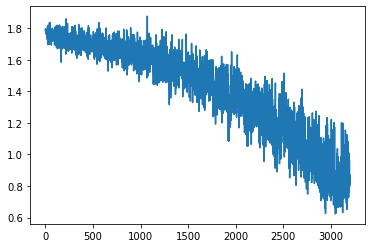

In [ ]:
import matplotlib.pyplot as plt

plt.plot(losses)

In [ ]:
# save best model configuration
torch.save(model.state_dict(), 'best_model_liar')

In [ ]:
# load best model configuration and run on test data
model.load_state_dict(torch.load('best_model_liar'))

<All keys matched successfully>

In [ ]:
test_dataset = ClassificationDatasetReader(test_data, bpemb_en)
test_dl = DataLoader(test_dataset, batch_size=len(test_data), collate_fn=collate_batch_bilstm, num_workers=8)

print(f"Valiation accuracy: {evaluate(model, valid_dl)}")
print(f"Test accuracy: {evaluate(model, test_dl)}")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()



Valiation accuracy: 0.23909657320872274



Test accuracy: 0.2494080505130229


For reference, these were the baseline accuracies published with [the paper](https://www.aclweb.org/anthology/P17-2067.pdf) (BiLSTM 0.223/0.233 validation/test accuracy):

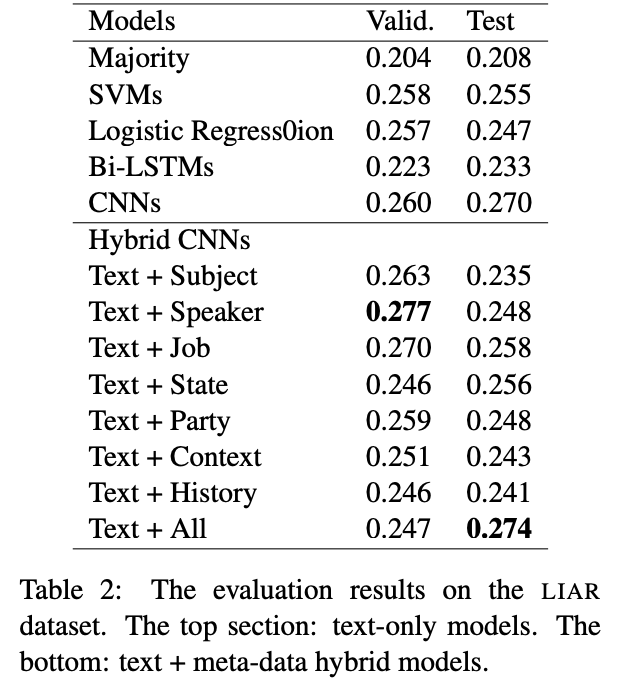

References 
- Introduction to Pytorch notebook from Stanford: https://nbviewer.jupyter.org/github/cgpotts/cs224u/blob/master/tutorial_pytorch.ipynb